## Imports

In [1]:
# Download Needed Packages
import sys
!{sys.executable} -m pip install -q pandas
!{sys.executable} -m pip install -q nltk
!{sys.executable} -m pip install -q sklearn
!{sys.executable} -m pip install -q wordcloud==1.8.1
!{sys.executable} -m pip install -q keras

In [2]:
# Import needed libraries and download needed data
import string
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

## Data Exploration

In [3]:
# Import Data
df = pd.read_csv("./fake_job_postings.csv")
print(f'{df.shape[0]} observations, {df.shape[1]} features')
display(df.head(5))

17880 observations, 18 features


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
# Print count of NaNs and type of each column
print("Column\t\t    NaNs   Type")
for column in df.columns:
    print(f'{column.ljust(20)}{str(df[column].isna().sum()).ljust(7)}{df[column].dtype}')

Column		    NaNs   Type
job_id              0      int64
title               0      object
location            346    object
department          11547  object
salary_range        15012  object
company_profile     3308   object
description         1      object
requirements        2695   object
benefits            7210   object
telecommuting       0      int64
has_company_logo    0      int64
has_questions       0      int64
employment_type     3471   object
required_experience 7050   object
required_education  8105   object
industry            4903   object
function            6455   object
fraudulent          0      int64


In [5]:
#Replacing NAN Values
NAN_Cols=[
    "location","department","salary_range",
    "company_profile","description","requirements",
    "benefits","employment_type","required_experience",
    "required_experience","required_education","industry","function"
]
print("Column\t\t       NaNs")
for i in NAN_Cols:
    df[i].fillna("",inplace=True)
print(df.isnull().sum())

Column		       NaNs
job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64


In [6]:
# Get numeric columns unique values
numeric_atts = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
for column in numeric_atts:
    print(f'{column}: {df[column].unique()}')

job_id: [    1     2     3 ... 17878 17879 17880]
telecommuting: [0 1]
has_company_logo: [1 0]
has_questions: [0 1]
fraudulent: [0 1]


<AxesSubplot:>

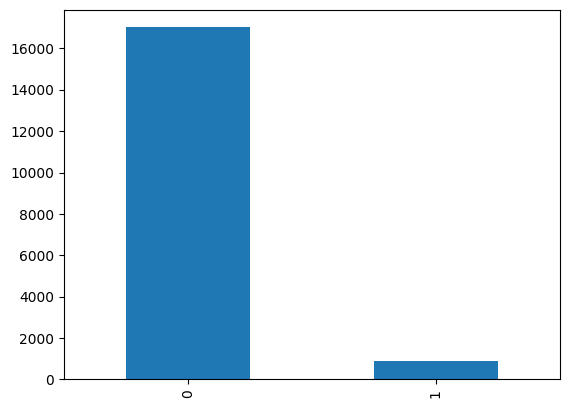

In [7]:
#Data Visualization
# plot of frequency of real jobs vs fraudulent jobs
df['fraudulent'].value_counts().plot.bar()

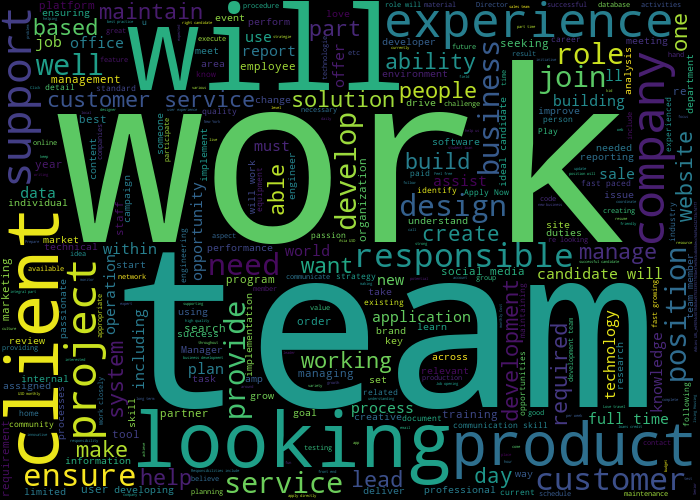

In [8]:
#top 300 most used words in the description

long_string = ','.join(list(df['description'].values))
wordcloud = WordCloud(background_color="black", max_words=500, width=700, height=500, contour_width=10, contour_color='green')
wordcloud.generate(long_string)
wordcloud.to_image()

In [9]:
display(df["benefits"].head(20))
df = df.replace(to_replace="(\s[a-z]{2,})([A-Z][a-z]*)",regex=True,value=r"\1 \2")
display(df["benefits"].head(20))

0                                                      
1     What you will get from usThrough being part of...
2                                                      
3     Our culture is anything but corporate—we have ...
4                                 Full Benefits Offered
5                                                      
6     Your Benefits: Being part of a fast-growing co...
7     Competitive Pay. You'll be able to eat steak e...
8                                                      
9                                                      
10    Benefits - FullBonus Eligible - YesInterview T...
11    You will join one of Europe’s most hotly tippe...
12                                                     
13                                                     
14    In return we'll pay you well, give you some ow...
15    Basic: SGD 120,000Equity negotiable for a rock...
16                                                     
17                                    Career pro

0                                                      
1     What you will get from us Through being part o...
2                                                      
3     Our culture is anything but corporate—we have ...
4                                 Full Benefits Offered
5                                                      
6     Your Benefits: Being part of a fast-growing co...
7     Competitive Pay. You'll be able to eat steak e...
8                                                      
9                                                      
10    Benefits - FullBonus Eligible - YesInterview T...
11    You will join one of Europe’s most hotly tippe...
12                                                     
13                                                     
14    In return we'll pay you well, give you some ow...
15    Basic: SGD 120,000Equity negotiable for a rock...
16                                                     
17                                    Career pro

## Preprocessing

In [10]:
# Convert Everything to lowercase
df = df.applymap(lambda s: s.lower() if type(s) == str else s)
display(df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,marketing intern,"us, ny, new york",marketing,,"we're food52, and we've created a groundbreaki...","food52, a fast-growing, james beard award-winn...",experience with content management systems a m...,,0,1,0,other,internship,,,marketing,0
1,2,customer service - cloud video production,"nz, , auckland",success,,"90 seconds, the worlds cloud video production ...",organised - focused - vibrant - awesome!do you...,what we expect from you:your key responsibilit...,what you will get from us through being part o...,0,1,0,full-time,not applicable,,marketing and advertising,customer service,0
2,3,commissioning machinery assistant (cma),"us, ia, wever",,,valor services provides workforce solutions th...,"our client, located in houston, is actively se...",implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,account executive - washington dc,"us, dc, washington",sales,,our passion for improving quality of life thro...,the company: esri – environmental systems rese...,"education: bachelor’s or master’s in gis, busi...",our culture is anything but corporate—we have ...,0,1,0,full-time,mid-senior level,bachelor's degree,computer software,sales,0
4,5,bill review manager,"us, fl, fort worth",,,spotsource solutions llc is a global human cap...,job title: itemization review managerlocation:...,qualifications:rn license in the state of texa...,full benefits offered,0,1,1,full-time,mid-senior level,bachelor's degree,hospital & health care,health care provider,0


In [11]:
# Remove Punctuation
punc_list = list(string.punctuation)
def remove_punctuation(text, punct_list):
    for punc in punct_list:
        if punc in text:
            text = text.replace(punc, ' ')
    return text

df = df.applymap(lambda s: remove_punctuation(s, punc_list) if type(s) == str else s)
display(df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,marketing intern,us ny new york,marketing,,we re food52 and we ve created a groundbreaki...,food52 a fast growing james beard award winn...,experience with content management systems a m...,,0,1,0,other,internship,,,marketing,0
1,2,customer service cloud video production,nz auckland,success,,90 seconds the worlds cloud video production ...,organised focused vibrant awesome do you...,what we expect from you your key responsibilit...,what you will get from us through being part o...,0,1,0,full time,not applicable,,marketing and advertising,customer service,0
2,3,commissioning machinery assistant cma,us ia wever,,,valor services provides workforce solutions th...,our client located in houston is actively se...,implement pre commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,account executive washington dc,us dc washington,sales,,our passion for improving quality of life thro...,the company esri – environmental systems rese...,education bachelor’s or master’s in gis busi...,our culture is anything but corporate—we have ...,0,1,0,full time,mid senior level,bachelor s degree,computer software,sales,0
4,5,bill review manager,us fl fort worth,,,spotsource solutions llc is a global human cap...,job title itemization review managerlocation ...,qualifications rn license in the state of texa...,full benefits offered,0,1,1,full time,mid senior level,bachelor s degree,hospital health care,health care provider,0


In [12]:
# Tokenize each text column
for column in df.columns:
    df[column] = df[column].apply(lambda s: word_tokenize(s) if type(s) == str else s)
display(df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,"[marketing, intern]","[us, ny, new, york]",[marketing],[],"[we, re, food52, and, we, ve, created, a, grou...","[food52, a, fast, growing, james, beard, award...","[experience, with, content, management, system...",[],0,1,0,[other],[internship],[],[],[marketing],0
1,2,"[customer, service, cloud, video, production]","[nz, auckland]",[success],[],"[90, seconds, the, worlds, cloud, video, produ...","[organised, focused, vibrant, awesome, do, you...","[what, we, expect, from, you, your, key, respo...","[what, you, will, get, from, us, through, bein...",0,1,0,"[full, time]","[not, applicable]",[],"[marketing, and, advertising]","[customer, service]",0
2,3,"[commissioning, machinery, assistant, cma]","[us, ia, wever]",[],[],"[valor, services, provides, workforce, solutio...","[our, client, located, in, houston, is, active...","[implement, pre, commissioning, and, commissio...",[],0,1,0,[],[],[],[],[],0
3,4,"[account, executive, washington, dc]","[us, dc, washington]",[sales],[],"[our, passion, for, improving, quality, of, li...","[the, company, esri, –, environmental, systems...","[education, bachelor, ’, s, or, master, ’, s, ...","[our, culture, is, anything, but, corporate—we...",0,1,0,"[full, time]","[mid, senior, level]","[bachelor, s, degree]","[computer, software]",[sales],0
4,5,"[bill, review, manager]","[us, fl, fort, worth]",[],[],"[spotsource, solutions, llc, is, a, global, hu...","[job, title, itemization, review, managerlocat...","[qualifications, rn, license, in, the, state, ...","[full, benefits, offered]",0,1,1,"[full, time]","[mid, senior, level]","[bachelor, s, degree]","[hospital, health, care]","[health, care, provider]",0


In [13]:
# Get descriptive columns and stopwords
descriptive_atts = ['company_profile', 'description', 'requirements', 'benefits']
stop_words = stopwords.words('english')

# Function to remove stopwords from an array of strings
def remove_stopwords(arr, remove):
    filtered = []
    for word in arr:
        if word not in remove:
            filtered.append(word)
    return filtered

# Remove common stopwords from strings in descriptive columns
for column in descriptive_atts:
    df[column] = df[column].apply(lambda s: remove_stopwords(s, stop_words) if type(s) == list else s)
display(df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,"[marketing, intern]","[us, ny, new, york]",[marketing],[],"[food52, created, groundbreaking, award, winni...","[food52, fast, growing, james, beard, award, w...","[experience, content, management, systems, maj...",[],0,1,0,[other],[internship],[],[],[marketing],0
1,2,"[customer, service, cloud, video, production]","[nz, auckland]",[success],[],"[90, seconds, worlds, cloud, video, production...","[organised, focused, vibrant, awesome, passion...","[expect, key, responsibility, communicate, cli...","[get, us, part, 90, seconds, team, gain, exper...",0,1,0,"[full, time]","[not, applicable]",[],"[marketing, and, advertising]","[customer, service]",0
2,3,"[commissioning, machinery, assistant, cma]","[us, ia, wever]",[],[],"[valor, services, provides, workforce, solutio...","[client, located, houston, actively, seeking, ...","[implement, pre, commissioning, commissioning,...",[],0,1,0,[],[],[],[],[],0
3,4,"[account, executive, washington, dc]","[us, dc, washington]",[sales],[],"[passion, improving, quality, life, geography,...","[company, esri, –, environmental, systems, res...","[education, bachelor, ’, master, ’, gis, busin...","[culture, anything, corporate—we, collaborativ...",0,1,0,"[full, time]","[mid, senior, level]","[bachelor, s, degree]","[computer, software]",[sales],0
4,5,"[bill, review, manager]","[us, fl, fort, worth]",[],[],"[spotsource, solutions, llc, global, human, ca...","[job, title, itemization, review, managerlocat...","[qualifications, rn, license, state, texasdipl...","[full, benefits, offered]",0,1,1,"[full, time]","[mid, senior, level]","[bachelor, s, degree]","[hospital, health, care]","[health, care, provider]",0


## Model Training

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import pad_sequences
from sklearn.metrics import accuracy_score

## Model that uses only the description column as X data

In [15]:
# Model that uses only the description column as X data
# Adds value to the word. Encoding the words to a numerical value
des_tokenizer = Tokenizer()
des_tokenizer.fit_on_texts(df['description'])
X = des_tokenizer.texts_to_sequences(df['description'])
X = pad_sequences(X, maxlen=500)
print(f'Rows of X: {len(X)}')
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=21)

model = Sequential()

model.add(Dense(units=50,activation="tanh",input_dim=500))
model.add(Dense(units=100, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')

model.fit(X_train, y_train, batch_size=5, epochs=5)


Rows of X: 17880
Epoch 1/5
2861/2861 [==============================] - 3s 734us/step - loss: 0.2084
Epoch 2/5
2861/2861 [==============================] - 2s 732us/step - loss: 0.2067
Epoch 3/5
2861/2861 [==============================] - 2s 724us/step - loss: 0.2060
Epoch 4/5
2861/2861 [==============================] - 2s 716us/step - loss: 0.2028
Epoch 5/5
2861/2861 [==============================] - 2s 712us/step - loss: 0.2037


In [16]:
# Threshold Results and Evaluate
# On Training Set
yTrain_hat=[1 if y>=0.5 else 0 for y in model.predict(X_train)]
print("Description Training: ")
print(classification_report(y_train,yTrain_hat))
print("Accuracy: ",accuracy_score(y_train,yTrain_hat))

# On Testing Set
y_hat=[1 if y>=0.5 else 0 for y in model.predict(X_test)]
print("Description Testing: ")
print(classification_report(y_test,y_hat))
print("Accuracy: ",accuracy_score(y_test,y_hat))

447/447 [==============================] - 0s 641us/step
Description Training: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13590
           1       0.42      0.09      0.15       714

    accuracy                           0.95     14304
   macro avg       0.69      0.54      0.56     14304
weighted avg       0.93      0.95      0.93     14304

Accuracy:  0.948336129753915
112/112 [==============================] - 0s 643us/step
Description Testing: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3424
           1       0.23      0.06      0.09       152

    accuracy                           0.95      3576
   macro avg       0.59      0.53      0.53      3576
weighted avg       0.93      0.95      0.94      3576

Accuracy:  0.9513422818791947


In [17]:
# Print Amount of Zeros and Ones Predicted
results = pd.DataFrame(y_hat)
print("Prediction")
print(results[0].value_counts())

compare = pd.DataFrame(y_test)
print("\nActual")
print(compare["fraudulent"].value_counts())

Prediction
0    3536
1      40
Name: 0, dtype: int64

Actual
0    3424
1     152
Name: fraudulent, dtype: int64


### Visualization of results from this model

In [18]:
#Make a new data frame with only columns for "description" and "fraudulent"
new_df = df.copy()
X = new_df['description']
y = new_df['fraudulent']
X_train, X_test, y_new_train, y_new_test = train_test_split(X, y,test_size=0.2, random_state=21)

y_df = pd.DataFrame(y_test)
x_df = pd.DataFrame(X_test)

test_df = x_df.join(y_df)
test_df

,description,fraudulent
9302,"[main, duties, responsibilities, responsible, ...",0
2400,"[company, introduction, joy, aether, leading, ...",0
1257,"[sprig, sprig, rapidly, expanding, technology,...",0
12511,"[owner, operators, wanted, amazing, opportunit...",0
13810,"[work, part, high, performance, team, implemen...",0
...,...,...
6969,"[government, funding, available, 16, 18, year,...",0
7386,"[network, engineer, bring, domain, specific, k...",0
13626,"[come, part, team, shape, influence, future, s...",0
6331,"[duration, 12, monthsrequired, skills, develop...",0


In [19]:
#Only consider the samples that are fraudulent
test_df = test_df[test_df.fraudulent == 1]
test_df

,description,fraudulent
2273,"[seeking, candidate, whose, core, values, incl...",1
17707,"[2176job, title, edi, coordinatorrole, informa...",1
17511,"[several, people, around, world, discovered, e...",1
1857,"[corporate, overview, aker, solutions, global,...",1
603,"[corporate, overview, aker, solutions, global,...",1
...,...,...
17794,"[preparation, monthly, invoices, commercial, i...",1
5720,"[demand, looking, people, quick, learners, eff...",1
7469,"[apply, using, link, directly, url, af5a535903...",1
2483,"[summary, responsible, timely, accurate, proce...",1


In [20]:
#Create a string of all words in the description of actual fraudulent job postings
finalString = ""
for i in range (len(test_df['description'].values)):
  for j in range (len(test_df['description'].values[i])):
    finalString = finalString + test_df['description'].values[i][j] + ",";
print(finalString)

seeking,candidate,whose,core,values,include,integrity,compassion,responsibility,focused,building,quality,relationships,clients,candidates,must,outstanding,organizational,skills,capable,responding,promptly,customer,needs,managing,duties,accuracy,thoroughness,candidates,must,also,able,work,home,minimal,amount,supervision,2176job,title,edi,coordinatorrole,information,technologyrelocation,available,short,easy,move,may,okay,industry,location,connecticuttown,city,norwalkjob,type,permanent,full,timejob,description,looking,edi,coordinator,expert,edi,850,860,870,855,using,inovis,software,well,programming,experience,cognos,sql,reporting,crystal,reporting,business,intelligence,development,data,etl,mapping,analysis,service,reporting,experience,using,ms,sql,server,ssis,ssas,ssrs,ms,sharepoint,knowledge,as400,rpg,400,helpful,edi,coordinator,prior,experience,networking,pc,cabling,microsoft,exchange,server,barracuda,email,archive,software,windows,products,business,intelligence,software,looking,ideal,c

<AxesSubplot:>

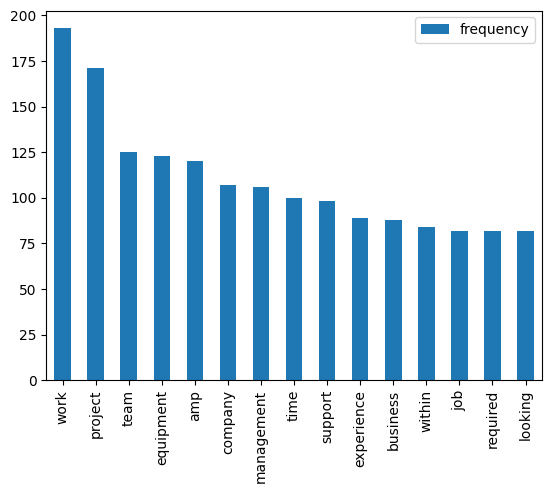

In [21]:
# Bar graph to visualize the frequency of 15 most used words in the actual fraudulent job postings

finalList = finalString.split(",")
from collections import Counter
counts = Counter(finalList)
graph_df = pd.DataFrame.from_dict(counts, orient="index", columns = ['frequency'])
graph_df = graph_df.sort_values(by=['frequency'])

ax = graph_df.tail(15)[::-1].plot.bar()
ax

In [22]:
#Create a data frame with samples that are predicted by our model to be fraudulent
test_predict_df = x_df
test_predict_df['fraudulent'] = y_hat
test_predict_df = test_predict_df[test_predict_df.fraudulent == 1]
test_predict_df

,description,fraudulent
1257,"[sprig, sprig, rapidly, expanding, technology,...",1
17715,"[accepting, online, applications, onlyclick, a...",1
3075,"[position, reports, head, engagement, manageme...",1
1761,"[great, clips, hair, salonwalk, right, 25, yea...",1
10638,"[looking, full, time, part, time, java, develo...",1
9905,"[support, growth, ’, looking, dedicated, brigh...",1
10170,"[customer, serivice, technical, specialist, ba...",1
6267,"[looking, qualified, project, manager, least, ...",1
2326,"[job, descriptionsupport, tendering, estimatio...",1
14397,"[namely, agile, startup, dedicated, building, ...",1


In [23]:
finalString = ""
for i in range (len(test_predict_df['description'].values)):
  for j in range (len(test_predict_df['description'].values[i])):
    finalString = finalString + test_predict_df['description'].values[i][j] + ",";
print(finalString)

sprig,sprig,rapidly,expanding,technology,company,provides,busy,san,franciscans,affordable,seasonal,handcrafted,meals,matter,minutes,culinary,team,creates,rotating,menu,locally,sourced,meals,servers,whisk,customers,faster,say,phone,fork,looking,enthusiasm,delicious,food,smile,sleeve,want,team,traditional,delivery,job,opportunity,join,us,ground,level,rapidly,expanding,technology,company,along,ride,driver,seat,handy,smartphone,keep,car,bike,pristine,shape,perk,one,free,meal,every,shift,accepting,online,applications,onlyclick,apply,full,time,temporary,position,lasting,2,years,descriptionvalidate,review,legal,contractual,agreements,customers,input,contract,contract,databases,contracts,completed,amp,reviewed,within,per,determined,service,level,agreement,professional,e,mail,interaction,customers,scanning,uploading,documents,qualificationshigh,school,diploma,equivalent,professional,communication,skills,via,e,mail,interaction,dedicated,needs,business,project,management,skills,assist,facilitatin

            frequency
                    1
kreuzberg           1
immediatly          1
paving              1
path                1
...               ...
business           35
’                  35
experience         35
work               43
team               45

[1782 rows x 1 columns]


<AxesSubplot:>

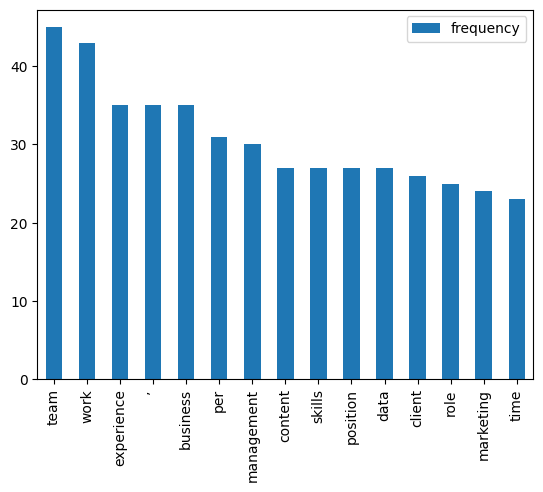

In [24]:
# Bar graph to visualize the frequency of 15 most used words in the predicted fraudulent job postings

finalList = finalString.split(",")
from collections import Counter
counts = Counter(finalList)
graph_df = pd.DataFrame.from_dict(counts, orient="index", columns=['frequency'])
graph_df = graph_df.sort_values(by=['frequency'])
print(graph_df)
ax = graph_df.tail(15)[::-1].plot.bar()
ax

## Model that uses only the company_profile column as X data

In [25]:
# Model that uses only the company_profile column as X data
prof_tokenizer = Tokenizer()
prof_tokenizer.fit_on_texts(df['company_profile'])
prof_X = prof_tokenizer.texts_to_sequences(df['company_profile'])
prof_X = pad_sequences(prof_X, maxlen=500)
y = df['fraudulent']
prof_X_train, prof_X_test, prof_y_train, prof_y_test = train_test_split(prof_X, y,test_size=0.2, random_state=21)

model = Sequential()

model.add(Dense(units=50,activation="tanh",input_dim=500))
model.add(Dense(units=100, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')

model.fit(prof_X_train, prof_y_train, batch_size=5, epochs=5)

Epoch 1/5
2861/2861 [==============================] - 2s 720us/step - loss: 0.1706
Epoch 2/5
2861/2861 [==============================] - 2s 746us/step - loss: 0.1617
Epoch 3/5
2861/2861 [==============================] - 2s 748us/step - loss: 0.1669
Epoch 4/5
2861/2861 [==============================] - 2s 769us/step - loss: 0.1606
Epoch 5/5
2861/2861 [==============================] - 2s 725us/step - loss: 0.1605


In [26]:
# Threshold Results and Evaluate
# On Training Set
prof_yTrain_hat=[1 if y>=0.5 else 0 for y in model.predict(prof_X_train)]
print("Company Profile Training: ")
print(classification_report(prof_y_train, prof_yTrain_hat))
print("Accuracy: ",accuracy_score(prof_y_train, prof_yTrain_hat))

# On Testing Set
prof_y_hat=[1 if y>=0.5 else 0 for y in model.predict(prof_X_test)]
print("\nCompany Profile Test: ")
print(classification_report(prof_y_test,prof_y_hat))
print("Accuracy: ",accuracy_score(prof_y_test,prof_y_hat))

447/447 [==============================] - 0s 632us/step
Company Profile Training: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     13590
           1       1.00      0.00      0.01       714

    accuracy                           0.95     14304
   macro avg       0.98      0.50      0.49     14304
weighted avg       0.95      0.95      0.93     14304

Accuracy:  0.9502936241610739
112/112 [==============================] - 0s 676us/step

Company Profile Test: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3424
           1       0.00      0.00      0.00       152

    accuracy                           0.96      3576
   macro avg       0.48      0.50      0.49      3576
weighted avg       0.92      0.96      0.94      3576

Accuracy:  0.9574944071588367


C:\Users\braxt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\braxt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\braxt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: Unde

In [27]:
# Print Amount of Zeros and Ones Predicted
results = pd.DataFrame(prof_y_hat)
print("Prediction")
print(results[0].value_counts())

compare = pd.DataFrame(y_test)
print("\nActual")
print(compare["fraudulent"].value_counts())

Prediction
0    3576
Name: 0, dtype: int64

Actual
0    3424
1     152
Name: fraudulent, dtype: int64


### Visualization of results from this model

In [38]:
# Create a new data frame that only has only "company_profile" and "fraudulent" as the columns.
# "company_profile" is from the original dataset.

new_df = df.copy()
X = new_df['company_profile']
y = new_df['fraudulent']
X_train, X_test, y_new_train, y_new_test = train_test_split(X, y,test_size=0.2, random_state=21)

y_df = pd.DataFrame(y_test)
x_df = pd.DataFrame(X_test)

test_df = x_df.join(y_df)
test_df

,company_profile,fraudulent
9302,"[thanks, visiting, job, board, please, review,...",0
2400,"[joy, aether, leading, provider, mobile, busin...",0
1257,"[sprig, rapidly, expanding, technology, compan...",0
12511,"[hawkeye, recruitment, provides, cost, effecti...",0
13810,"[ensight, international, energy, design, imple...",0
...,...,...
6969,"[established, principles, full, time, educatio...",0
7386,"[upstream, ’, mission, revolutionise, way, com...",0
13626,"[keycafe, leading, key, exchange, solution, ai...",0
6331,"[rhb, recruitment, ltd, business, process, out...",0


In [39]:
# Only consider the fraudulent company profiles
test_df = test_df[test_df.fraudulent == 1]
test_df

,company_profile,fraudulent
2273,"[gary, cartwright, established, cartwright, pr...",1
17707,[],1
17511,[],1
1857,"[aker, solutions, global, provider, products, ...",1
603,"[aker, solutions, global, provider, products, ...",1
...,...,...
17794,[],1
5720,[],1
7469,[],1
2483,[],1


In [40]:
# Create a string with all the company_profiles.
finalString = ""
for i in range (len(test_df['company_profile'].values)):
  for j in range (len(test_df['company_profile'].values[i])):
    finalString = finalString + test_df['company_profile'].values[i][j] + ",";
print(finalString)

gary,cartwright,established,cartwright,property,management,2007,help,manage,hoas,created,development,company,would,develop,residential,multi,family,community,developed,numerous,single,family,duplex,townhome,apartment,communities,gary,general,contractor,holding,unlimited,building,license,licensed,real,estate,agent,north,carolina,gary,also,partner,sister,real,estate,company,experience,builder,developer,real,estate,sales,company,owner,beneficial,assisting,rental,hoa,clients,managing,rentals,hoa,communities,aker,solutions,global,provider,products,systems,services,oil,gas,industry,engineering,design,technology,bring,discoveries,production,maximize,recovery,petroleum,field,employ,approximately,28,000,people,30,countries,go,url,0fa3f7c5e23a16de16a841e368006cae916884407d90b154dfef3976483a71ae,information,business,people,values,aker,solutions,global,provider,products,systems,services,oil,gas,industry,engineering,design,technology,bring,discoveries,production,maximize,recovery,petroleum,field,em

<AxesSubplot:>

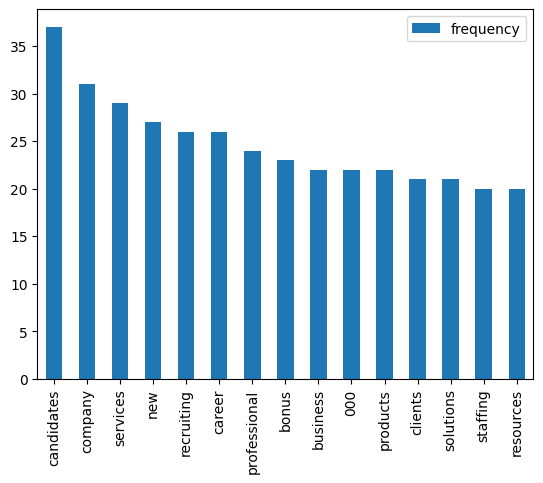

In [41]:
# Bar graph that helps visualize the frequency of most used words in company profile.
finalList = finalString.split(",")
from collections import Counter
counts = Counter(finalList)
graph_df = pd.DataFrame.from_dict(counts, orient="index", columns=['frequency'])
graph_df = graph_df.sort_values(by=['frequency'])

ax = graph_df.tail(15)[::-1].plot.bar()
ax

In [42]:
#Create a data frame with samples that are predicted by our model to be fraudulent
test_predict_df = x_df
test_predict_df['fraudulent'] = prof_y_hat
test_predict_df = test_predict_df[test_predict_df.fraudulent == 1]
test_predict_df

,company_profile,fraudulent


In [43]:
finalString = ""
for i in range (len(test_predict_df['company_profile'].values)):
  for j in range (len(test_predict_df['company_profile'].values[i])):
    finalString = finalString + test_predict_df['company_profile'].values[i][j] + ",";
print(finalString)

<AxesSubplot:>

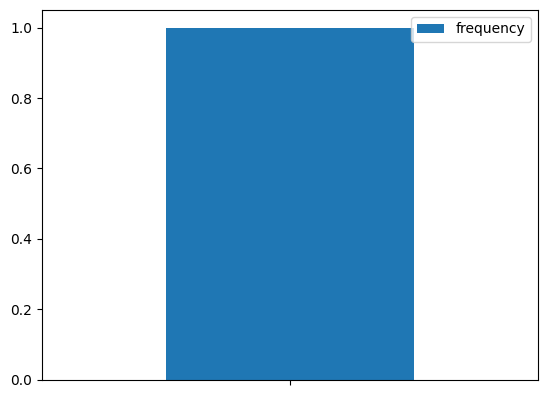

In [44]:
# Bar graph that helps visualize the frequency of most used words in company profile.
finalList = finalString.split(",")

from collections import Counter
counts = Counter(finalList)
graph_df = pd.DataFrame.from_dict(counts, orient="index", columns=['frequency'])
graph_df = graph_df.sort_values(by=['frequency'])

ax = graph_df.tail(15)[::-1].plot.bar()
ax